In [1]:
import os
import sys
import json
import time
from pathlib import Path

import gspread
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy import signal, fftpack

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import (
    get_stim_events,
    get_evoked_traces,
    get_evoked_firing_rates,
    find_nearest_ind
)
from allensdk.brain_observatory.ecephys.lfp_subsampling.subsampling import remove_lfp_offset

In [4]:
%matplotlib notebook

In [5]:
plotsdir = r"C:\Users\lesliec\OneDrive - Allen Institute\Shared Documents - Lab 328\Probe Targeting\probe cleaning"

Load Templeton-log_exp to get metadata for experiments

In [6]:
_gc = gspread.service_account() # need a key file to access the account
_sh = _gc.open('Templeton-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
expmetadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe

In [7]:
data_dir = Path("P:/")

In [8]:
pcolors = {'probeB': 'orangered', 'probeC': 'orchid', 'probeD': 'royalblue', 'probeF': 'mediumseagreen'}

## Checking probe quality over time
<br>On 02/09/2024 probeF was replaced due to having some bad chs. Recordings past that date have all the same probes.

In [16]:
# mouse_list = ['709402', '720762', '724057', '728449', '730913', '730911', '735049', '735050'] # 02/09/24-present
# mouse_list = [
#     '703063', '703064', '703065', '709401', '709400', '709402', '720762', '724057', '728449', '730913',
#     '730911', '735049', '735050'
# ] # 11/15/23-present
mouse_list = [
    '666193', '666194', '666196', '669117', '673449', '676726', '676727', '678912', '678913', '689242', '689239', '689240',
    '703063', '703064', '703065', '709401', '709400', '709402', '720762', '724057', '728449', '730913', '730911', '735049',
    '735050'
] # 02/15/23-present

In [17]:
all_probe_counts = []
for mousei in mouse_list:
    mousemeta = expmetadata[(expmetadata['mouse_name'].str.contains(mousei))].squeeze()
    for ii, mrow in mousemeta.iterrows():
        print('{}: {}'.format(mrow.mouse_name, mrow.exp_name))
        dataloc = os.path.join(data_dir, mrow.mouse_name, mrow.exp_name, 'experiment1', 'recording1')
        exp = EEGexp(dataloc, preprocess=False, make_stim_csv=False)
        probe_list = [x.replace('_sorted', '') for x in exp.experiment_data if 'probe' in x]
        for probei in probe_list:
            cluster_group = pd.read_csv(exp.ephys_params[probei]['cluster_group'], sep='\t')
            cluster_metrics = pd.read_csv(exp.ephys_params[probei]['cluster_metrics'])
            unit_metrics = pd.merge(cluster_group.rename(columns={'group':'label'}), cluster_metrics, on='cluster_id')
            num_clusters = len(unit_metrics)
            good_metrics = unit_metrics[(
                (unit_metrics['label'] == 'good') & (unit_metrics['isi_viol'] < 0.5) &
                (unit_metrics['amplitude_cutoff'] < 0.1) & (unit_metrics['firing_rate'] > 0.05)
            )]
            num_units = len(good_metrics)
            all_probe_counts.append([mousei, mrow.exp_name, exp.date, probei, num_clusters, num_units])
    print('')
    
probe_metrics = pd.DataFrame(all_probe_counts, columns=['mouse', 'exp_type', 'date', 'probe', 'clusters', 'units'])

mouse666193: pilot_aw_2023-02-15_11-44-11
Experiment type: electrical stimulation
mouse666193: pilot_aw_psi_2023-02-16_10-55-48
This data does not contain an EEG recording.
Experiment type: electrical stimulation
mouse666193: pilot_ur_2023-02-17_12-22-51
This data does not contain an EEG recording.
Experiment type: electrical stimulation

mouse666194: pilot_aw_2023-02-22_12-32-58
Experiment type: electrical stimulation
mouse666194: pilot_aw_psi_2023-02-23_10-40-34
Experiment type: electrical stimulation
mouse666194: pliot_ur_2023-02-24_11-19-43
Experiment type: electrical stimulation

mouse666196: pilot_aw_2023-03-15_12-29-06
Experiment type: electrical and sensory stimulation
mouse666196: pilot_aw_psi_2023-03-16_10-21-29
Experiment type: electrical and sensory stimulation

mouse669117: pilot_aw_2023-03-29_11-09-15
Experiment type: electrical stimulation
mouse669117: pilot_aw_psi_2023-03-30_11-37-07
Experiment type: electrical stimulation
mouse669117: pilot_ur_2023-03-31_11-51-53
Exper

In [18]:
probe_metrics.head()

,mouse,exp_type,date,probe,clusters,units
0,666193,pilot_aw_2023-02-15_11-44-11,2023-02-15 11:44:11,probeB,746,343
1,666193,pilot_aw_2023-02-15_11-44-11,2023-02-15 11:44:11,probeC,760,318
2,666193,pilot_aw_2023-02-15_11-44-11,2023-02-15 11:44:11,probeD,632,252
3,666193,pilot_aw_2023-02-15_11-44-11,2023-02-15 11:44:11,probeF,1188,651
4,666193,pilot_aw_psi_2023-02-16_10-55-48,2023-02-16 10:55:48,probeB,624,303


<IPython.core.display.Javascript object>


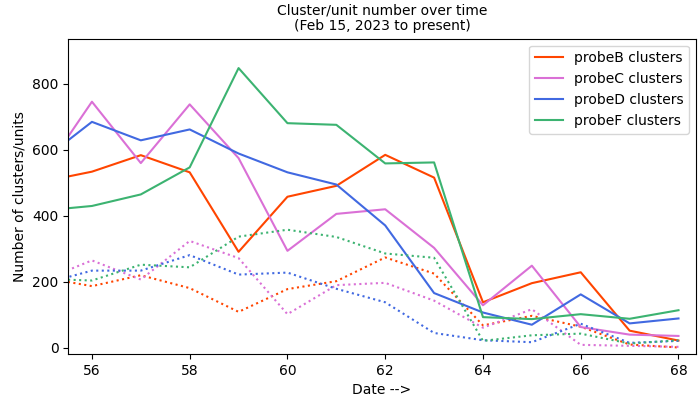

In [20]:
fig, ax = plt.subplots(figsize=(7,4), constrained_layout=True)
for probei in probe_list:
    p_df = probe_metrics[probe_metrics['probe'] == probei]
    
    ax.plot(p_df.clusters.values, color=pcolors[probei], label='{} clusters'.format(probei))
    ax.plot(p_df.units.values, color=pcolors[probei], linestyle='dotted')#, label='{} units'.format(probei))
    
ax.legend()
ax.set_ylabel('Number of clusters/units')
ax.set_xlabel('Date -->')

ax.set_title('Cluster/unit number over time\n(Feb 15, 2023 to present)')

## Save ##
figname = 'probe_cluster_number_Feb152023-present.png'
# fig.savefig(os.path.join(plotsdir, figname), transparent=False, dpi=150)

In [83]:
tpdf = probe_metrics[probe_metrics['probe'] == 'probeC']
tpdf[60:69]

,mouse,exp_type,date,probe,clusters,units
241,730911,aw_sal_2024-05-01_11-57-16,2024-05-01 11:57:16,probeC,294,102
245,730911,aw_ket_2024-05-02_10-41-41,2024-05-02 10:41:41,probeC,406,190
249,730911,aw_stim_train_2024-05-03_10-33-23,2024-05-03 10:33:23,probeC,420,197
253,735049,aw_sal_2024-05-22_11-05-25,2024-05-22 11:05:25,probeC,303,143
257,735049,aw_ket_2024-05-23_11-42-08,2024-05-23 11:42:08,probeC,129,61
261,735049,aw_stim_train_2024-05-24_10-36-53,2024-05-24 10:36:53,probeC,249,117
265,735050,aw_sal_2024-05-29_10-07-49,2024-05-29 10:07:49,probeC,63,9
269,735050,aw_psi_2024-05-30_09-46-15,2024-05-30 09:46:15,probeC,40,6
273,735050,aw_sal2_2024-05-31_10-24-49,2024-05-31 10:24:49,probeC,36,3


# NPX signal spectrum (before and after cleaning with 10% tergazyme)

In [39]:
salinetest = {
    'before': r"W:\mouse000000\sal_test_2024-06-03_11-48-45\experiment1\recording1",
    'after': r"W:\mouse000000\sal_test2_2024-06-05_11-07-53\experiment1\recording1",
}

probe_list = {'ProbeB': 'orangered', 'ProbeC': 'orchid', 'ProbeD': 'royalblue', 'ProbeF': 'mediumseagreen'}
data_type = 'AP'
SR = 30000 # samples/s
testwin = 120 # s
bitvolts = 0.195

testsamps = int(testwin * SR)

In [41]:
freq_data = {}
for testi, dataloc in salinetest.items():
    freq_data[testi] = {}
    for probei in probe_list.keys():
        ## Load data ##
        data_ts = np.load(os.path.join(dataloc, 'continuous', 'Neuropix-PXI-100.{}-{}'.format(probei, data_type), 'sample_numbers.npy'))
        data_mm = np.memmap(
            os.path.join(dataloc, 'continuous', 'Neuropix-PXI-100.{}-{}'.format(probei, data_type), 'continuous.dat'),
            dtype='int16', shape=(data_ts.size, 384), mode='r'
        )
        ## Get spectrum for sample window ##
        test_data = data_mm[:testsamps, :] * bitvolts
        frex, Pxx = signal.welch(test_data, SR, nperseg=2 * SR, axis=0)
        freq_data[testi][probei] = [frex, Pxx]
        
        del data_ts, data_mm, test_data, frex, Pxx

<IPython.core.display.Javascript object>


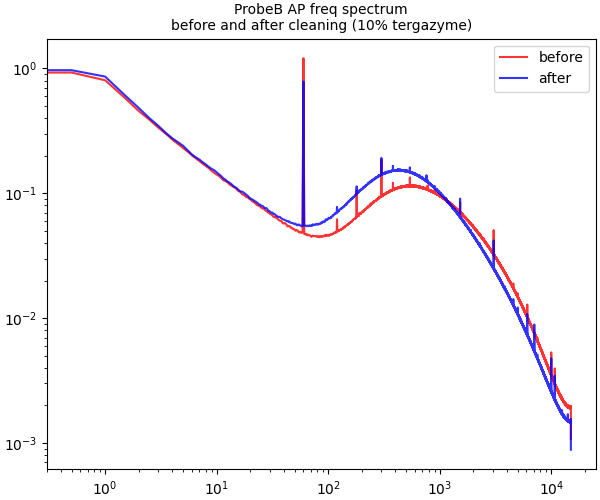

In [55]:
pp = 'ProbeB'

fig, ax = plt.subplots(figsize=(6,5), constrained_layout=True)

for testi, lst in zip(freq_data.keys(), ['red', 'blue']):
    frex = freq_data[testi][pp][0]
    Pxx = freq_data[testi][pp][1]

    ax.loglog(frex, np.mean(Pxx, axis=1), color=lst, linewidth=1.5, alpha=0.8, label=testi)

ax.set_title('{} {} freq spectrum\nbefore and after cleaning (10% tergazyme)'.format(pp, data_type))
ax.legend()
## Save ##
figname = '{} {} freq_cleaning.png'.format(pp, data_type)
# fig.savefig(os.path.join(plotsdir, figname), transparent=False, dpi=150)

<IPython.core.display.Javascript object>


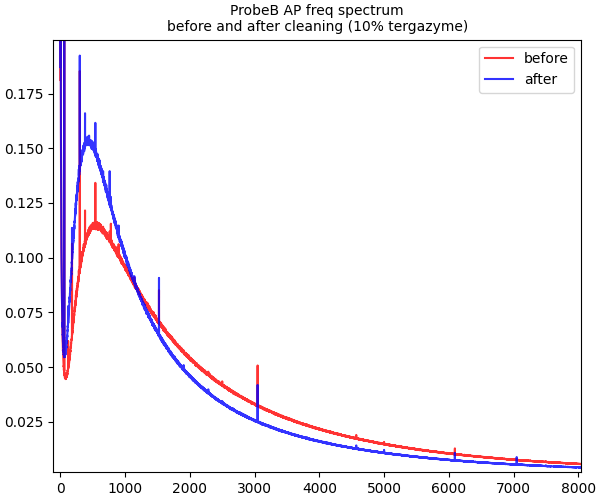

In [56]:
pp = 'ProbeB'

fig, ax = plt.subplots(figsize=(6,5), constrained_layout=True)

for testi, lst in zip(freq_data.keys(), ['red', 'blue']):
    frex = freq_data[testi][pp][0]
    Pxx = freq_data[testi][pp][1]

    ax.plot(frex, np.mean(Pxx, axis=1), color=lst, linewidth=1.5, alpha=0.8, label=testi)

ax.set_title('{} {} freq spectrum\nbefore and after cleaning (10% tergazyme)'.format(pp, data_type))
ax.legend()
## Save ##
figname = '{} {} freq_cleaning.png'.format(pp, data_type)
# fig.savefig(os.path.join(plotsdir, figname), transparent=False, dpi=150)

<IPython.core.display.Javascript object>


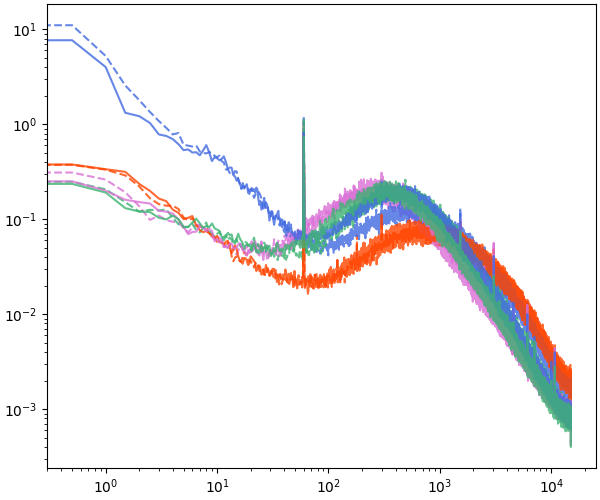

In [60]:
plch = 380 # 'all'

fig, ax = plt.subplots(figsize=(6,5), constrained_layout=True)

for testi, lst in zip(freq_data.keys(), ['dashed', 'solid']):
    for probei, pcol in probe_list.items():
        frex = freq_data[testi][probei][0]
        Pxx = freq_data[testi][probei][1]
        if plch == 'all':
            ax.loglog(frex, np.mean(Pxx, axis=1), color=pcol, linewidth=1.5, alpha=0.8, linestyle=lst)
        else:
            ax.loglog(frex, Pxx[:,plch], color=pcol, linewidth=1.5, alpha=0.8, linestyle=lst)

### Testing

# NPX signal spectrum (in vivo, before and after decrease in clusters)

In [9]:
subexp = {
    'before': r"P:\mouse735049\aw_sal_2024-05-22_11-05-25\experiment1\recording1",
    'after': r"P:\mouse735049\aw_ket_2024-05-23_11-42-08\experiment1\recording1",
}

probe_list = {'probeB': 'orangered', 'probeC': 'orchid', 'probeD': 'royalblue', 'probeF': 'mediumseagreen'}
data_type = 'ap'
SR = 30000 # samples/s
testwin = 120 # s
bitvolts = 0.195

testsamps = int(testwin * SR)

In [10]:
freq_data = {}
for testi, dataloc in subexp.items():
    print(dataloc)
    exp = EEGexp(dataloc, preprocess=False, make_stim_csv=False)
    freq_data[testi] = {}
    for probei in probe_list.keys():
        print(' {}'.format(probei))
        ## Load data ##
        data_ts = np.load(exp.ephys_params[probei]['{}_timestamps'.format(data_type)])
        data_mm = np.memmap(
            exp.ephys_params[probei]['{}_continuous'.format(data_type)],
            dtype='int16', shape=(data_ts.size, 384), mode='r'
        )
        ## Get spectrum for sample window ##
        test_data = data_mm[:testsamps, :] * bitvolts
        frex, Pxx = signal.welch(test_data, SR, nperseg=2 * SR, axis=0)
        freq_data[testi][probei] = [frex, Pxx]
        
        del data_ts, data_mm, test_data, frex, Pxx

P:\mouse735049\aw_sal_2024-05-22_11-05-25\experiment1\recording1
Experiment type: electrical and sensory stimulation
 probeB
 probeC
 probeD
 probeF
P:\mouse735049\aw_ket_2024-05-23_11-42-08\experiment1\recording1
Experiment type: electrical and sensory stimulation
 probeB
 probeC
 probeD
 probeF


<IPython.core.display.Javascript object>


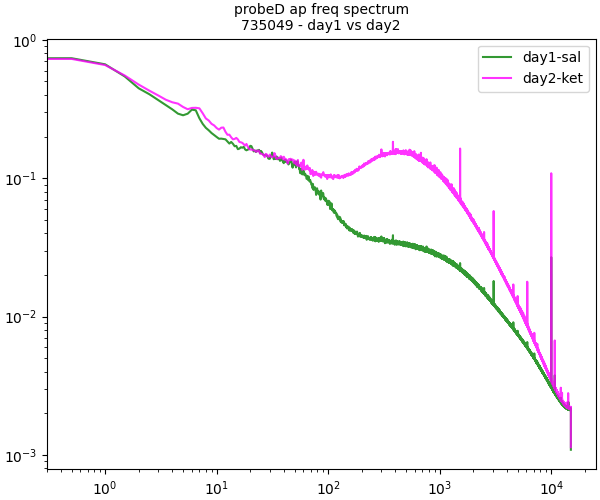

In [15]:
pp = 'probeD'

fig, ax = plt.subplots(figsize=(6,5), constrained_layout=True)

for testi, lst, lbl in zip(freq_data.keys(), ['green', 'magenta'], ['day1-sal', 'day2-ket']):
    frex = freq_data[testi][pp][0]
    Pxx = freq_data[testi][pp][1]

    ax.loglog(frex, np.mean(Pxx, axis=1), color=lst, linewidth=1.5, alpha=0.8, label=lbl)

ax.set_title('{} {} freq spectrum\n735049 - day1 vs day2'.format(pp, data_type))
ax.legend()
## Save ##
figname = '{} {} freq_735049.png'.format(pp, data_type)
# fig.savefig(os.path.join(plotsdir, figname), transparent=False, dpi=150)

<IPython.core.display.Javascript object>


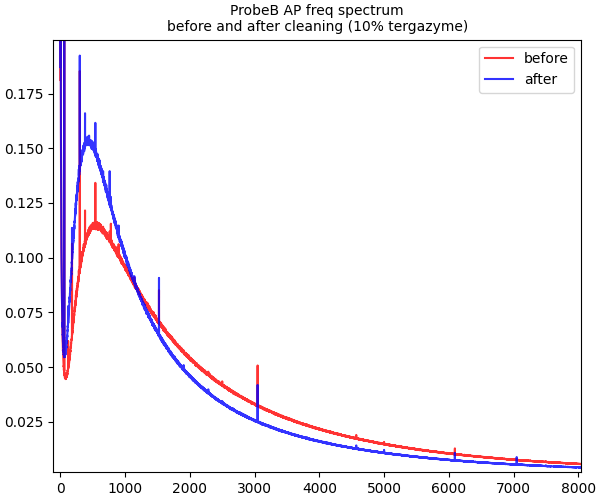

In [56]:
pp = 'ProbeB'

fig, ax = plt.subplots(figsize=(6,5), constrained_layout=True)

for testi, lst in zip(freq_data.keys(), ['red', 'blue']):
    frex = freq_data[testi][pp][0]
    Pxx = freq_data[testi][pp][1]

    ax.plot(frex, np.mean(Pxx, axis=1), color=lst, linewidth=1.5, alpha=0.8, label=testi)

ax.set_title('{} {} freq spectrum\nbefore and after cleaning (10% tergazyme)'.format(pp, data_type))
ax.legend()
## Save ##
figname = '{} {} freq_cleaning.png'.format(pp, data_type)
# fig.savefig(os.path.join(plotsdir, figname), transparent=False, dpi=150)